
# Variant Calling Workflow for *Hesperapis oraria*

**Author**: Gabriel Zayas

## Overview

This notebook outlines a step-by-step workflow for calling genetic variants in the *Hesperapis oraria* genome project. The workflow involves processing raw Whole Genome Sequencing (WGS) data, aligning it to a reference genome, and identifying variants using industry-standard tools such as GATK and DeepVariant. 

This guide will walk you through each step, providing the necessary commands and explanations to understand and replicate the analysis.



## Project Description

The goal of this project is to identify genetic variants within the *Hesperapis oraria* population using WGS data. The workflow consists of the following key steps:

1. **Quality Control**: Assess raw reads quality using FastQC.
2. **Read Trimming**: Remove low-quality sequences and adapters with Trim_Galore.
3. **Mapping**: Align trimmed reads to the reference genome using BWA.
4. **Alignment Quality Assessment**: Evaluate the quality of the alignment with Qualimap.
5. **Duplicate Removal**: Remove PCR duplicates using Picard.
6. **Variant Calling**: Identify genetic variants with GATK and DeepVariant.
7. **Merging and Filtering**: Merge variant calls and perform quality control.


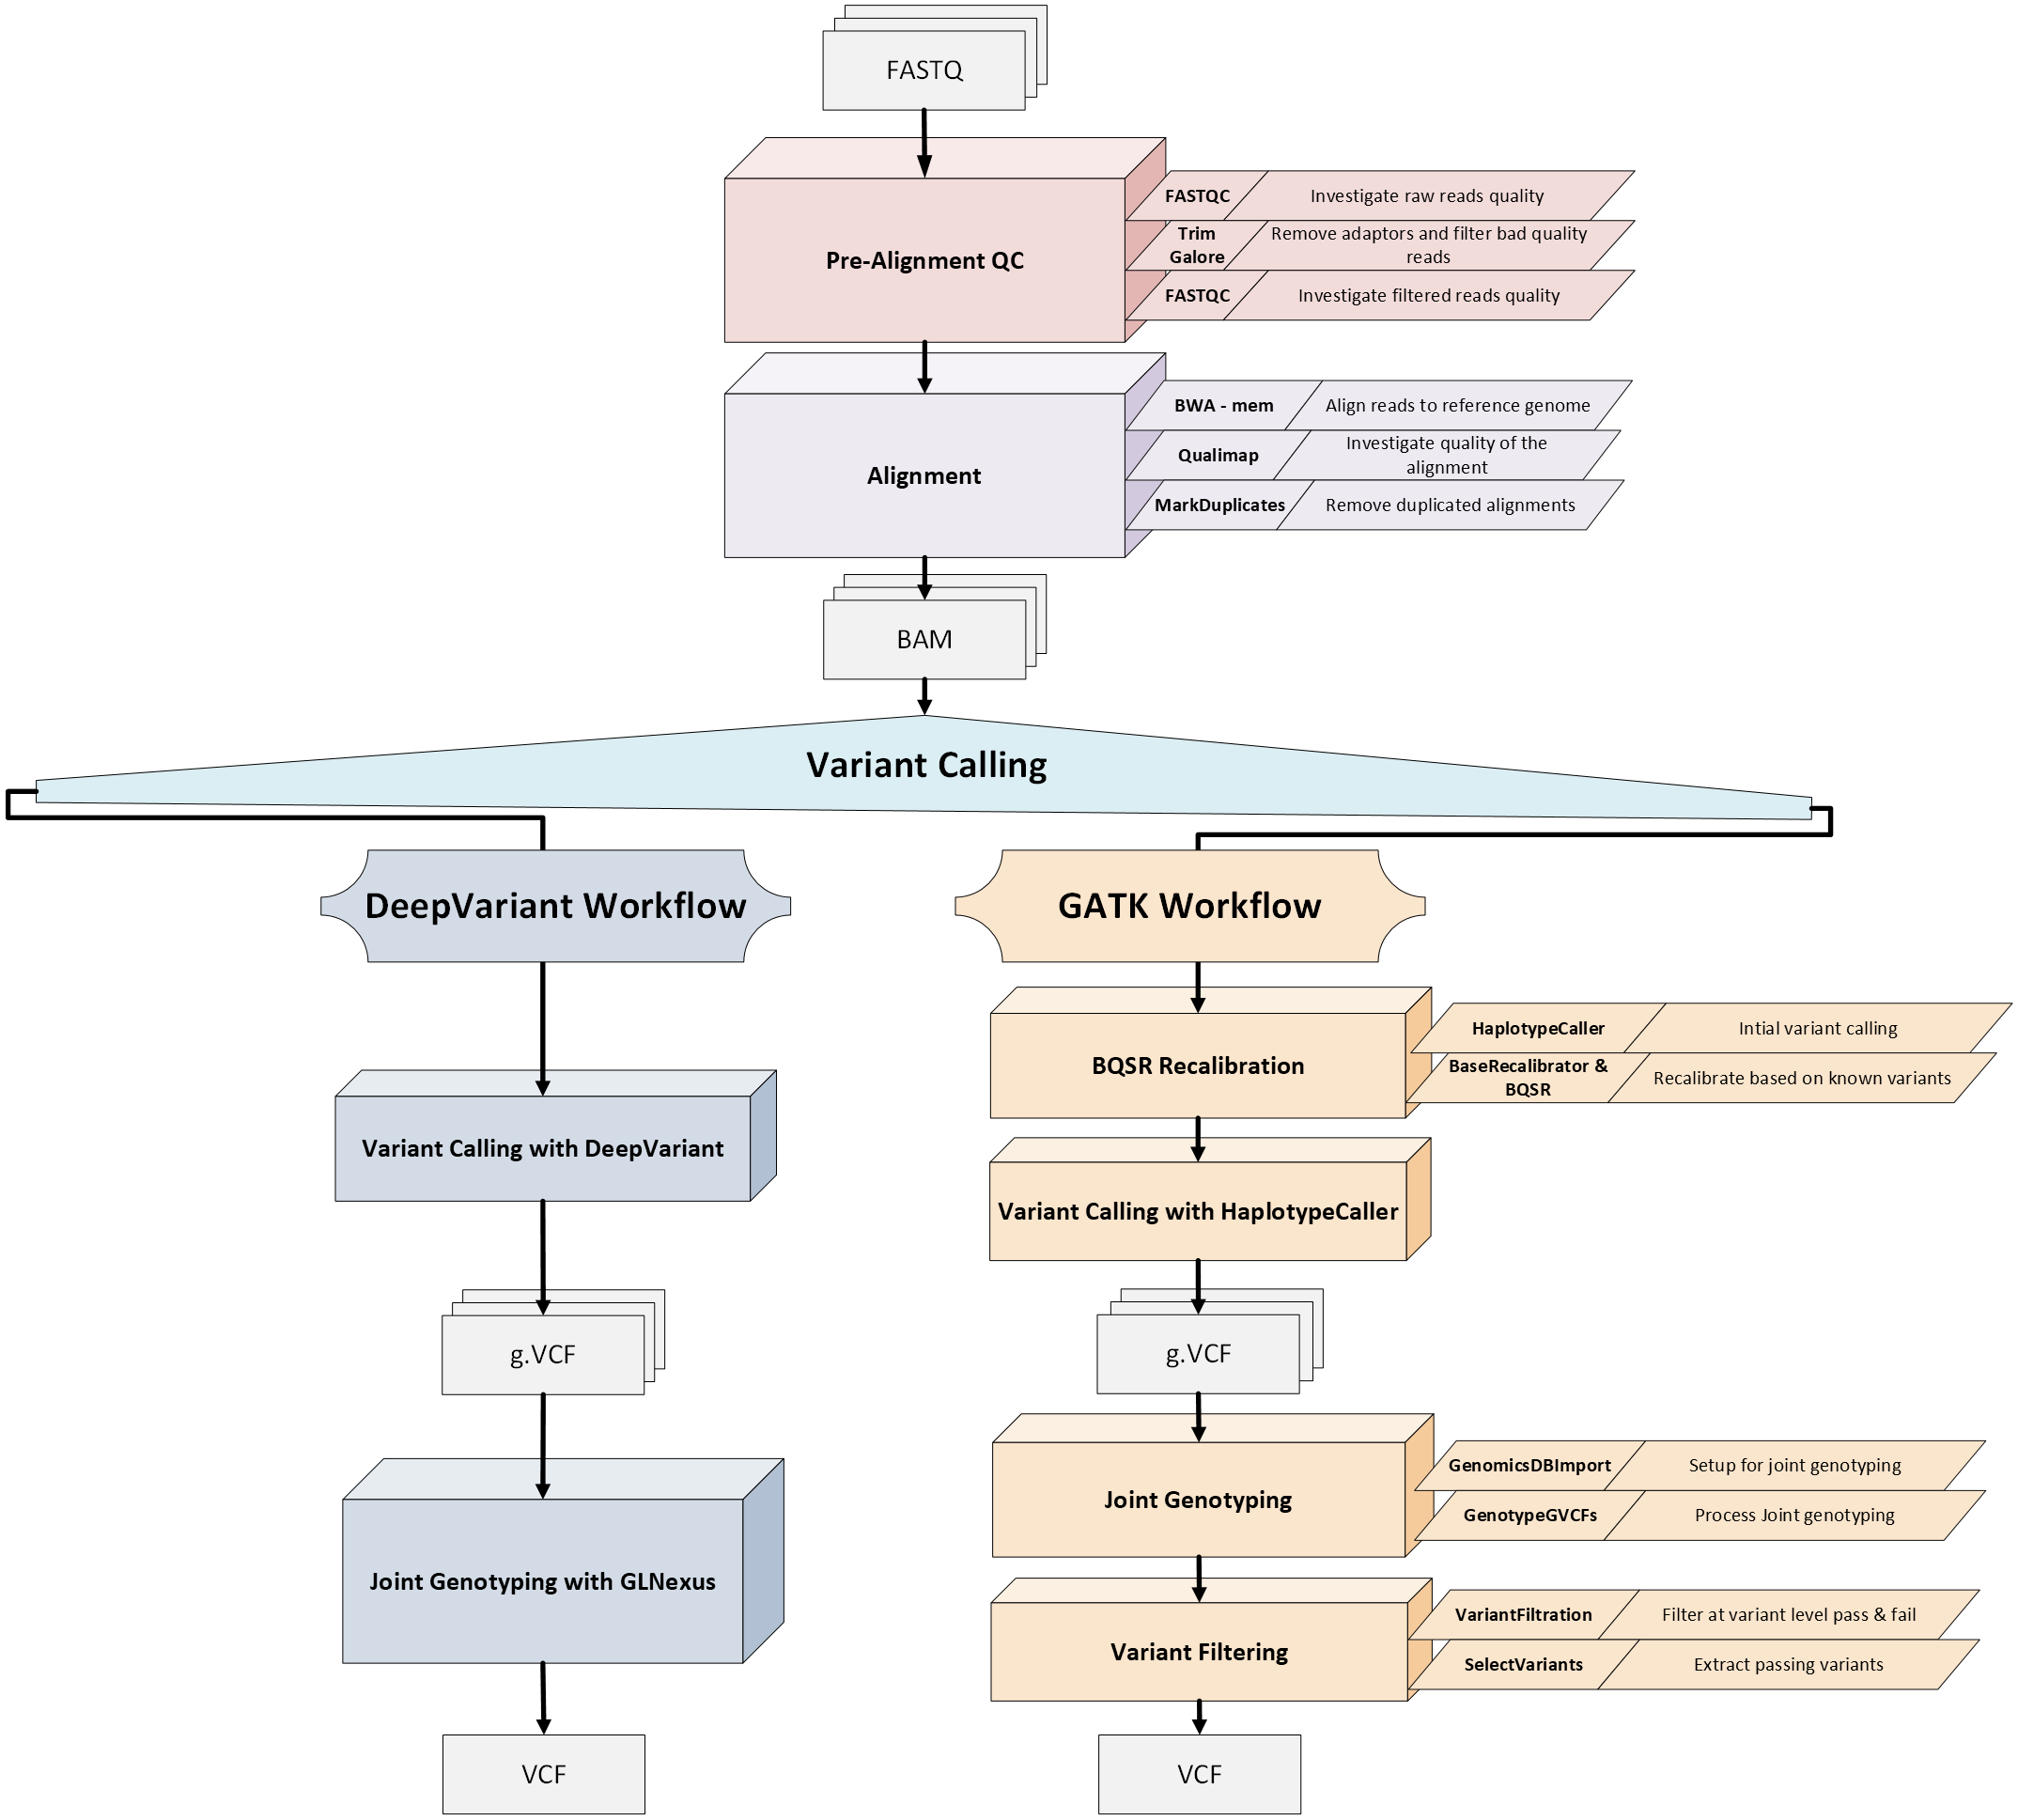

In [11]:
from IPython.display import Image, display
# Define the path to your script file
file_path = 'VC_project_env.sh'

# Initialize a variable to store the directory path
my_docs_dir = None

# Open and read the file line by line
with open(file_path, 'r') as file:
    for line in file:
        # Check if the line starts with "export my_docs="
        if line.startswith('export my_docs='):
            # Extract the directory path after the "=" sign
            my_docs_dir = line.split('=')[1].strip().strip('"')
            break
# Check if the directory was found and construct the image path
if my_docs_dir:
    workflow_image_path = f"{my_docs_dir}/Variant Calling Workflow.png"
    # Display the image within the notebook
    display(Image(filename=workflow_image_path, width=1000, height = 1000))
else:
    print("The my_docs directory was not found in the script.")


## Step 0: Setting Up the Environment

Before starting the variant calling process, set up the computational environment by creating and activating a conda environment. This environment contains all the necessary tools for the workflow.

**Script:** `0.Setup.sh`

This script sets up the necessary directories and installs the required software packages.


In [1]:
# Check if the conda environment is activated and the necessary directories exist
import os
# Execute the environment setup script
!bash 0.Setup.sh

Project Directory: /project/90daydata/beenome100/hesperapis_oraria_genomics/Test.Hesperapis_oraria_Pop_genomics
Code Directory: /project/90daydata/beenome100/hesperapis_oraria_genomics/Test.Hesperapis_oraria_Pop_genomics/code/Variant_Calling/
Data Directory: /project/90daydata/beenome100/hesperapis_oraria_genomics/Test.Hesperapis_oraria_Pop_genomics/data/
Results Directory: /project/90daydata/beenome100/hesperapis_oraria_genomics/Test.Hesperapis_oraria_Pop_genomics/results/Variant_Calling/



## Step 1: Quality Control & Trimming

### Quality Control with FastQC

FastQC is used to assess the quality of raw sequencing reads. It generates detailed reports that help identify issues such as low-quality bases, overrepresented sequences, and adapter contamination.

### Trimming with Trim_Galore

Trim_Galore is employed to trim adapters and remove low-quality sequences from the reads, ensuring higher accuracy in subsequent alignment and variant calling steps.

**Script:** `1.0.runQC_Trim.sh`

This script automates the process of running FastQC and Trim_Galore on all raw reads. It reads the FASTQ filenames and executes the necessary trimming and quality control procedures using the `trim_qualitycontrol.V2.sh` script.


In [ ]:
!sbatch 1.0.runQC_Trim.sh

Project Directory: /project/90daydata/beenome100/hesperapis_oraria_genomics/Test.Hesperapis_oraria_Pop_genomics
Code Directory: /project/90daydata/beenome100/hesperapis_oraria_genomics/Test.Hesperapis_oraria_Pop_genomics/code/Variant_Calling/
Data Directory: /project/90daydata/beenome100/hesperapis_oraria_genomics/Test.Hesperapis_oraria_Pop_genomics/data/
Results Directory: /project/90daydata/beenome100/hesperapis_oraria_genomics/Test.Hesperapis_oraria_Pop_genomics/results/Variant_Calling/


## Step 2: BWA Alignment

### Alignment with BWA

The alignment process is a critical step in the variant calling workflow. It involves mapping the trimmed reads to the reference genome to determine their exact location within the genome. This is essential for identifying genetic variants with high precision.

**Script:** `2.0.Alignment.sh`

This script automates the alignment of your trimmed reads to the reference genome using the BWA-MEM algorithm, which is specifically designed for high-throughput sequencing data. The process includes several steps:

- **Parallel Processing:** The script processes multiple FASTQ files in parallel, improving efficiency and reducing overall runtime.
- **Alignment:** The `alignment.sh` script reads the names and paths of the trimmed short-read files and aligns them to the reference genome using BWA-MEM.
- **SAM to BAM Conversion:** The output from BWA, which is initially in SAM format, is sorted and converted to BAM format, a more compact and efficient format for downstream processing.
- **Quality Assessment with Qualimap:** After alignment, a Qualimap report is generated for each sample. This report provides insights into the quality of the alignment, including metrics such as coverage depth and uniformity, ensuring the data is suitable for subsequent analysis.

In [ ]:
!sbatch 2.0.Alignment.sh

## Step 3: Mark Duplicates in BAM & Initial Variant Calling

### Marking Duplicates and Initial Variant Calling

After the alignment step, it's important to identify and remove duplicate reads in the BAM files. Duplicate reads can arise during PCR amplification and can introduce bias in variant calling if not properly handled. Once duplicates are marked, we proceed with the initial variant calling.

**Script:** `3.0.runCleaning.sh`

This script performs two crucial tasks in parallel:

- **Duplicate Removal:** The script reads the names of the BAM files generated during the alignment step and processes them with the `cleaning.bam.sh` script. This script marks and removes duplicate reads from the BAM files to ensure that only unique reads contribute to variant calling.
  
- **Initial Variant Calling with HaplotypeCaller:** After cleaning the BAM files, the script proceeds with initial variant calling using GATK's HaplotypeCaller. During this step, ploidy differences between males and females are accounted for, ensuring accurate variant identification in both sexes.

In [ ]:
!sbatch 3.0.runCleaning.sh 

**Script:** `3.5.Initial_variants.sh`

This shell script works with `initial_joint.genotyping.sh` in the scripts directory. These scripts initiate the joint genotyping process. Due to the large size of the data, the joint genotyping is performed separately by scaffold. Each scaffold is genotyped independently, and the resulting files are later merged to produce the final variant dataset.

In [ ]:
!sbatch 3.5.Initial_variants.sh

**Script:** `3.75.Merge_initial.calls.sh`

The `Merge_initial.calls.sh` script combines the variant calls from individual scaffolds into a single, unified dataset. In addition to merging the data, this script also performs genotypic quality control to ensure the accuracy and reliability of the merged variants.

In [ ]:
!sbatch 3.75.Merge_intial.calls.sh

## Step 4: Final Variant Calling

In this step, we conduct the final variant calling using both GATK and DeepVariant. This allows for a comparison between traditional methods and deep learning-based approaches in identifying genetic variants.

**Script:** `4.0.Variant_Calling.sh`

This script initiates the final variant calling process, utilizing both GATK and DeepVariant. By comparing the results from these two approaches, we gain insights into the differences and potential advantages of deep learning over traditional variant calling methods.


In [ ]:
!sbatch 4.0.Variant_Calling.sh

**Script:** `4.5.Final_variants.sh`

This script performs the final genotyping step using GATK, ensuring that all identified variants are accurately genotyped according to the specified parameters.

In [ ]:
!sbatch 4.5.Final_variants.sh

## Step 5: Merging Final Genotyping Calls

After the final variant calling, the genotypes need to be merged to create a unified variant dataset. This step ensures that all variants identified across scaffolds and different methods are accurately represented.

**Scripts:**

- `5.0.Merge_variants.sh`: This script merges the VCF files produced by GATK across different scaffolds, consolidating them into a single VCF file.
- `Deep.variant_merge.sh`: This script merges the gVCF files generated by DeepVariant, creating a unified variant dataset into a single VCF file.

In [ ]:
!sbatch 5.0.Merge_variants.sh
!sbatch Deep.variant_merge.sh 